AI Programming - SW Lee

# Lab 08: Deep Q Learning Network (a.k.a DQN)
## Exercise: Cart Pole, Lunar Lander

### Prepare Library Packages

In [1]:
# Check if this code runs in Colab
RunningInCOLAB = 'google.colab' in str(get_ipython())

# Installing the required library and Import tqdm for notebook if Colab
if RunningInCOLAB:
    !pip install swig
    !pip install gymnasium
    !pip install gymnasium[box2d]
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

  Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376474 sha256=158c8e5ce2c10c25b13e20e43a578e100f85dc5715f0b95eaba611a868338afa
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import os
# Setting the Keras backend to TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importing necessary libraries
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import wrappers

from collections import deque
import random

In [3]:
# List available GPU devices
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
# Enable memory growth for the first GPU
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Print an error message if no GPU is detected
except:
    print('GPU is not detected.')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Check the installed version
gym.__version__

'1.0.0'

### Select Environment

**Cart Pole**<br>
https://gymnasium.farama.org/environments/classic_control/cart_pole/

**Lunar Lander**<br>
https://gymnasium.farama.org/environments/box2d/lunar_lander/

In [5]:
# select evironment
# Discrete Action Space:    0 for Cartpole, 1 for LunarLander

SELECT_ENV = 1

In [6]:
# If the selected environment is 0 (CartPole)
if SELECT_ENV == 0:
    # Set environment configurations
    env_name, res_prefix = 'CartPole-v1', 'cart'
    max_episodes, max_ep_steps, goal_score = 400, 500, 450
    b_size, h_size = 128, 1000
    network_type, state_width, state_height, state_depth = 'dense', 0, 0, 0
    kwargs = {'render_mode':'rgb_array'}
# If the selected environment is 1 (LunarLander)
elif SELECT_ENV == 1:
    # Set environment configurations
    env_name, res_prefix = 'LunarLander-v3', 'lunD'
    max_episodes, max_ep_steps, goal_score = 400, 1000, 200
    b_size, h_size = 128, 10000
    network_type, state_width, state_height, state_depth = 'dense', 0, 0, 0
    kwargs = {'continuous':False, 'render_mode':'rgb_array'}
# If the environment selection is invalid
else: assert False, 'environment selection error'

# Function to create the environment
def create_env():
    env = gym.make(env_name, **kwargs)
    return env

In [7]:
# Function to reset the environment
def env_reset(env):
    observation = env.reset()
    state = observation[0] if type(observation)==tuple else observation
    return state

 # Function to take a step in the environment
def env_step(env, action):
    observation = env.step(action)
    state = observation[0]
    reward = observation[1]
    done = observation[2] or observation[3] if len(observation)>4 else observation[2]
    return state, reward, done

In [8]:
# Create the environment, reset it to get the initial state,
# and take a random step to get the new state, reward, and done flag
env = create_env()
state = env_reset(env)
state, reward, done = env_step(env, env.action_space.sample())

### Check and Show Environment Variables

In [9]:
# Set action space parameters based on its type
action_shape = env.action_space.shape
action_space_type = type(env.action_space)

# For discrete actions: define action range and shape
if action_space_type==gym.spaces.discrete.Discrete:
    actn_space = 'DISCRETE'
    action_shape = (1,)
    action_dims = 1
    action_range = env.action_space.n
    num_actions = action_range  # number of actions is action range for DISCRETE actions
    action_batch_shape = (None, action_range)
# For continuous actions: define action range, bounds, and shape
elif action_space_type==gym.spaces.box.Box:
    actn_space = 'CONTINUOUS'
    action_dims = action_shape[0]
    actn_uppr_bound = env.action_space.high[0]
    actn_lowr_bound = env.action_space.low[0]
    action_range = (actn_uppr_bound - actn_lowr_bound) # x0.5 for tanh output
    action_batch_shape = tuple([None]+[x for x in action_shape])
    num_actions = action_dims   # number of actions is action dimension for CONTINUOUS actions
else: assert False, 'other action space type are not supported'

# Set observation space parameters based on its type
observation_space_type = type(env.observation_space)
observation_shape = env.observation_space.shape

# For discrete observations: set number of states
if observation_space_type==gym.spaces.discrete.Discrete:
    observation_shape = (1,)
    num_states = env.observation_space.n
# For continuous observations: set number of states
elif observation_space_type==gym.spaces.box.Box:
    num_states = observation_shape[0]
else: print('observation space type error')

# Set batch shapes for state and value
state_shape = observation_shape
state_batch_shape = tuple([None]+[x for x in observation_shape])

value_shape = (1,)
num_values = 1

In [10]:
# Print details about action space, observation space, state space, and value shape
print('Action space ', action_space_type)
print('Action shape ', action_shape)
print('Action dimensions ', action_dims)
print('Action range ', action_range)
if action_space_type==gym.spaces.box.Box:
    print('Max Value of Action ', actn_uppr_bound)
    print('Min Value of Action ', actn_lowr_bound)
else: pass
print('Action batch shape ', action_batch_shape)

print('Observation space ', observation_space_type)
print('Observation shape ', observation_shape)
print('Size of State Space ', num_states)
print('State shape ', state_shape)
print('State batch shape ', state_batch_shape)

print('Vallue shape ', value_shape)
print('Value dimensions ', num_values)

Action space  <class 'gymnasium.spaces.discrete.Discrete'>
Action shape  (1,)
Action dimensions  1
Action range  4
Action batch shape  (None, 4)
Observation space  <class 'gymnasium.spaces.box.Box'>
Observation shape  (8,)
Size of State Space  8
State shape  (8,)
State batch shape  (None, 8)
Vallue shape  (1,)
Value dimensions  1


### Define and Initialize The Agent
### **Exercise:** Define Deep Q-network (TensorFlow)

A NN of three fully-connected layers is enough for classic control problems.<br>

**Parameters for layer definition are:**<br>
hiddens = (unit # for layer1, unit # for layer2),<br>
act_fn: activation function,<br>
out_fn: activation function for output layer, <br>
init_fn: kernel initialization function

In [11]:
# DQNet defines a deep Q-network model
def DQNet(hiddens, act_fn, out_fn, init_fn):    # hiddends = (layer1 units, layer2 units)
    inputs = keras.Input(shape=state_shape)  # input layer

    ### START CODE HERE ###

    l1 = tf.keras.layers.Dense(units=hiddens[0], activation=act_fn, kernel_initializer=init_fn)(inputs)   # first fully connected layer
    l2 = tf.keras.layers.Dense(units=hiddens[1], activation=act_fn, kernel_initializer=init_fn)(l1)       # second fully connected layer
    outputs = tf.keras.layers.Dense(units=num_actions, activation=out_fn, kernel_initializer=init_fn)(l2) # output (third) layer

    ###  END CODE HERE  ###

    model = keras.Model(inputs=inputs, outputs=outputs, name='q_net') # Create Keras model object
    return model

# DQNet model creation function
def build_DQNet():
    model = DQNet(hiddens=(32,32), act_fn='relu', out_fn='linear', init_fn='he_uniform')
    return model

In [12]:
# Create the DQNet model and display
test_model = build_DQNet()
test_model.summary()
del test_model

Model: "q_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,476 (5.77 KB)

 Trainable params: 1,476 (5.77 KB)

 Non-trainable params: 0 (0.00 B)

**Model Summary:**

```
┏--------------------------------------┳-----------------------------┳-----------------┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡--------------------------------------╇-----------------------------╇-----------------┩
│ input_layer (InputLayer)             │ (None, 4 or 8)              │               0 │
├--------------------------------------┼-----------------------------┼-----------------┤
│ dense (Dense)                        │ (None, 32)                  │      160 or 288 │
├--------------------------------------┼-----------------------------┼-----------------┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├--------------------------------------┼-----------------------------┼-----------------┤
│ dense_2 (Dense)                      │ (None, 2 or 4)              │       66 or 132 │
└--------------------------------------┴-----------------------------┴-----------------┘
```

The policy function in the Agent_Net is just for getting a SINGLE sample, not for training. So you have to set `training=False` if necessary.
Since the network takes batch format (i.e., `[batch,data]`), the input state should be given as `[None,...]` and the output should be taken as `[0,...]`.

### **Exercise:** Define Policy Functions

In [13]:
# Agent_Net defines a reinforcement learning agent with policy and target networks for Q-learning
class Agent_Net:
    def __init__(self):
        self.policy_q = build_DQNet()                       # Build policy network
        self.target_q = build_DQNet()                       # Build target network
        self.target_update()                                # Copy weights from policy to target

    def policy(self, state, epsilon, exploring):            # Epsilon-greedy policy if exploring
        state_input = tf.convert_to_tensor(state[None,...], dtype=tf.float32)   # Make the state network-ready

        ### START CODE HERE ###

        if exploring:                                       # If e-greedy policy
            if tf.random.uniform(()) > epsilon:             # Exploit if random>epsilon
                action_q = self.policy_q(state_input)       # Get actions for input state
                action = tf.argmax(action_q[0])             # Find an action for maximum q value
            else:                                           # Explore else
                action = tf.random.uniform((), 0, action_range, tf.int64)       # Random action
        else:                                                                   # Else greedy policy (exploitation)
            action_q = self.policy_q(state_input)                               # Get actions for input state
            action = tf.argmax(action_q[0])                                     # Find an action for maximum q value

        ###  END CODE HERE  ###

        return action.numpy()

    def target_update(self):
        self.target_q.set_weights(self.policy_q.get_weights())  # Copy weights from policy network to target network
        return

In [14]:
# Test_policy simulates an epsilon-greedy policy for action selection
def test_policy(exploring):

    epsilon = 0.1                           # Set epsilon value for exploration
    state_input = tf.random.uniform((1,3))  # Randomly generate a state input
    action_range = 7                        # Number of possible actions

    # Pretending policy_q network
    def policy_q(x):
        x = tf.random.uniform((tf.shape(x)[0],action_range)) # Generate random action values
        return x

    ### START CODE HERE ###

    if exploring:                                           # If using epsilon-greedy policy
        if tf.random.uniform(()) > epsilon:                 # Exploit if random > epsilon
          action_q = policy_q(state_input)                  # Get Q-values for input state
          action = tf.argmax(action_q[0])                   # Find an action for maximum q value
        else:                                               # Explore else take random action
          action = tf.random.uniform((), 0, action_range, tf.int64) # Random action selection                                                    #   random action
    else:                                                   # Else greedy policy (exploitation)
         action_q = policy_q(state_input)                   # Get Q-values for input state
         action = tf.argmax(action_q[0])                    #  Find an action for maximum q value

    ###  END CODE HERE  ###

    return action # Return selected action

tf.random.set_seed(2) # Set seed for reproducibility
# Print actions when exploring
for _ in range(10): print(test_policy(True).numpy(), ' ', end='')
# Print actions when exploiting
for _ in range(10): print(test_policy(False).numpy(), ' ', end='')

5  0  6  5  1  3  1  4  5  0  3  1  6  0  1  2  0  3  6  4  

**Expected Outputs:**

```
5  0  6  5  1  3  1  4  5  0  3  1  6  0  1  2  0  3  6  4
```

### Define and Initialize Replay Memory

The replay memory (or replay buffer) is implemented with `deque`, which maintians the fixed number of elements by discarding the oldest element automatically.<br>
The inputs of the `put_experience` function are from environments and the outputs of the `get_batch` function are fed to the NN. Therefore the output types should be tensors.

In [15]:
# ReplayMemory stores and manages experiences for replay buffer in reinforcement learning
class ReplayMemory:
    def __init__(self, memory_size):
        self.experiences = deque(maxlen=memory_size)    # Allocate replay memory
        self.num_episodes = 0                           # Set number of episode to zero

    def put_experience(self, experience):               # Put an experience into replay memory
        state, action, next_state, reward, not_done = experience
        self.experiences.append((state, action, next_state, reward, not_done)) # Store experience
        return

    def get_batch(self, num_samples):                   # Get a batch of randomly sampled experiences
        state_batch, next_state_batch, action_batch, reward_batch, not_done_batch = [], [], [], [], []

        sample_batch = random.sample(self.experiences, num_samples) # Randomly sample experiences

        # Extract and store individual components of each sample
        for sample in sample_batch:
            state, action, next_state, reward, not_done = sample
            state_batch.append(state)
            action_batch.append(action)
            next_state_batch.append(next_state)
            reward_batch.append(reward)
            not_done_batch.append(not_done)

        # Convert batches to tensors
        batch = (tf.convert_to_tensor(state_batch, dtype=tf.float32),
                tf.convert_to_tensor(action_batch, dtype=tf.int32),
                tf.convert_to_tensor(next_state_batch, dtype=tf.float32),
                tf.convert_to_tensor(reward_batch, dtype=tf.float32),
                tf.convert_to_tensor(not_done_batch, dtype=tf.float32))
        return batch # Return the batch of experiences

### **Exercise:** Initialize the replay memory

A single experience consists of `(state, action, next_state, reward, not_done)`. Be careful with **`not_done`**.

In [16]:
# Init_memory initializes the replay memory by interacting with the environment for a specified number of sample
def init_memory(mem, env, agent, num_samples):
    state = env_reset(env)                          # Initialize environment
    # Loop over the number of samples
    for _ in range(num_samples):

        ### START CODE HERE ###
        action = agent.policy(state, epsilon=1.0, exploring=True)     # Get an action with the policy
        next_state, reward, done = env_step(env, action)              # Observe the environment reaction
        experience = (state, action, next_state, reward, not done)    # Pack observations into experience tuple
        mem.put_experience(experience)                                # Put the experience to replay memory
        state = env_reset(env) if done else next_state                # Set the next state (reset env if done)

        ###  END CODE HERE  ###

    return

In [17]:
# Set random seeds for reproducibility and initialize components for testing
tf.random.set_seed(2)
keras.utils.set_random_seed(2)
test_agent = Agent_Net()
test_mem = ReplayMemory(4)
test_env = create_env()
test_state = test_env.reset(seed=3)
init_memory(test_mem, test_env, test_agent, 4)

if SELECT_ENV==1:
    print(test_mem.get_batch(4)[0][0][:4].numpy())
    print(test_mem.get_batch(4)[1].numpy())
    print(test_mem.get_batch(4)[2][0][:4].numpy())
    print(test_mem.get_batch(4)[3].numpy())
    print(test_mem.get_batch(4)[4].numpy())
else:
    print(test_mem.get_batch(4)[0][0][:4].numpy())
    print(test_mem.get_batch(4)[1].numpy())
    print(test_mem.get_batch(4)[2][0][:4].numpy())
    print(test_mem.get_batch(4)[3].numpy())
    print(test_mem.get_batch(4)[4].numpy())

del test_agent, test_mem
test_env.close()

[-0.01505842  1.4191642  -0.76619244  0.17035668]
[1 0 1 0]
[-0.03796177  1.427054   -0.7755038   0.08992036]
[-1.0618883 -1.0290995 -1.9180926 -1.4797792]
[1. 1. 1. 1.]


**Expected Outputs:**

```
[-0.04072088  0.18846463 -0.00277539 -0.32736924]
[1 0 1 0]
[-0.02550636 -0.00617038 -0.02836518 -0.04544564]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
```
or
```
[-0.01505842  1.4191642  -0.76619244  0.17035668]
[1 0 1 0]
[-0.03796177  1.427054   -0.7755038   0.08992036]
[-1.0618883 -1.0290995 -1.9180926 -1.4797792]
[1. 1. 1. 1.]
```

### Learning Procedures

DQN trains the Q-network to minimize the difference:

$$ \delta_t = (r_{t} + \gamma \max_{\hat{a}_{t+1}} Q_T(s_{t+1}, \hat{a}_{t+1}; \theta_T)) - Q_P(s_t, a_t; \theta_P) $$

where $Q_T$ is a target network and $Q_P$ policy network.

Then the loss function is

$$ L(\theta_P) = \delta_t^2 $$

### **Exercise:** Define ONE step of Training Loop and Evaluation Loop

The following test has same codes as the `dqn_train` function except the last line.

In [18]:
# Computes Q-values, target rewards, and generates ground truth labels for training
def test_training():
    state_b = tf.random.uniform((3,4)) # Batch of states (b, s)
    action_b = tf.random.uniform((3,), minval=0, maxval=7, dtype=tf.int32) # Batch of actions (b,)
    next_state_b = tf.random.uniform((3,4)) # Batch of next states (b, s)
    reward_b = tf.random.uniform((3,)) # Batch of rewards (b,)
    not_done_b = tf.random.uniform((3,)) # Indicator for whether the episode has ended (b,)
    gamma = tf.random.uniform((1,)) # Discount factor (scalar)
    action_range = 7 # The number of possible actions

    class test_agent:
        def __init__(self):
            pass
        def policy_q(self, x):
            return tf.reduce_sum(x, axis=-1, keepdims=True) # Q-value from policy network (b, 1)
        def target_q(self, x):
            return tf.reduce_sum(x, axis=-1, keepdims=True) # Q-value from target network (b, 1)

    agent = test_agent()

    ### START CODE HERE ###

    # Get action probability with current (think of WHY!!) policy (b,a)
    # Get the current Q-values (b,1) from the policy network
    curr_q = agent.policy_q(state_b)

    # get action probability with target policy (b,a),
    # and then find the max Q value with it (b,)
    # Get the Q-values (b,1) from the target network for the next state
    next_q = agent.target_q(next_state_b)
    max_next_q = tf.reduce_max(next_q, axis=-1)

    # Calculate target reward using the Bellman equation (b,1)
    target_reward = reward_b + gamma * max_next_q * not_done_b

    # Make one-hot actions (b,a) to filter out other actions
    action_v = tf.one_hot(action_b, action_range)

    # Make ground true labels for training (b,a)
    label_q = curr_q * (1 - action_v) + target_reward[:, None] * action_v
    ###  END CODE HERE  ###

    return label_q

In [19]:
# Set random seed for reproducibility
tf.random.set_seed(2)

# Define the expected result for the training labels
ans = np.array([[1.1889474 , 1.1889474 , 1.1889474 , 1.1889474 , 1.1889474 , 1.1889474 , 0.40853113],
                [2.713482  , 2.713482  , 2.4351463 , 2.713482  , 2.713482  , 2.713482  , 2.713482  ],
                [3.3669732 , 1.4427134 , 3.3669732 , 3.3669732 , 3.3669732 , 3.3669732 , 3.3669732 ]])
# Call the function to get training labels
res = test_training()
print('Training lable test passed.') if np.allclose(res,ans) else print('Training lable test failed.')

Training lable test passed.


In [20]:
# Trains the DQN agent by updating its policy network using the given batch of experiences
def dqn_train(agent, batch, config):
    state_b, action_b, next_state_b, reward_b, not_done_b = batch # Unpack the batch
    gamma = config.gamma # Discount factor from the config

    ### START CODE HERE ###

    # get action probability with current (think of WHY!!) policy (b,a)
    # Get the current Q-values from the policy network (b, a) where a is the number of actions
    curr_q = agent.policy_q(state_b)

    # get action probability with target policy (b,a),
    # and then find the max Q value with it (b,)
    # Get the Q-values from the target network for the next states (b, a)
    next_q = agent.target_q(next_state_b)
    max_next_q = tf.reduce_max(next_q, axis=-1)

    # Calculate target reward (b,1)
    target_reward = reward_b + gamma * max_next_q * not_done_b

    # Make one-hot actions (b,a) to filter out other actions
    action_v = tf.one_hot(action_b, action_range)

    # Make ground true labels for training (b,a)
    label_q = curr_q * (1 - action_v) + target_reward[:, None] * action_v

    # Training with model.fit()
    logs = agent.policy_q.fit(state_b, label_q, epochs=1, verbose=0)

    ###  END CODE HERE  ###

    # Get the loss from the training logs
    loss = logs.history['loss'][-1]
    return loss

In [21]:
# To evaluate the performance of the agent by averaging rewards over multiple episodes
def evaluate_policy(env, agent, num_avg):

    total_reward = 0.0
    episodes_to_play = num_avg
    for i in range(episodes_to_play): # Play n episode and take the average
        state = env_reset(env)        # Reset environment and get initial state
        done = False
        episode_reward = 0.0
        while not done:

            ### START CODE HERE ###

            action = agent.policy(state, epsilon=0.0, exploring=False)  # Get an action with policy
            next_state, reward, done = env_step(env, action)            # Take action and observe outcomes

            ###  END CODE HERE  ###

            state = next_state           # Update state
            episode_reward += reward     # Accumulate reward for the episode
        total_reward += episode_reward   # Add the episode reward to total reward

    # Calculate the average reward across all episodes
    average_reward = total_reward / episodes_to_play

    return average_reward

### Define Epsilon Function

This is an example of exponential decay epsilon function. One of easist epsilon decay functions is simply to multiply 0.9. You can define your own epsilon function.

In [22]:
# Exploration parameters for epsilon greedy strategy
class Epsilon:
    def __init__(self, max_episodes, decay_speed=1.0):
        self.explore_start = 1.0            # Exploration probability at start
        self.explore_stop = 0.01            # Minimum exploration probability
        self.decay_rate = decay_speed/max_episodes  # Exp decay rate for exploration prob (10/max ≈ 0.99)
        self.episode_cnt = 0                # Episode counter

    def get_epsilon(self):
        # Calculate epsilon based on exponential decay
        eps = (self.explore_stop
            + (self.explore_start - self.explore_stop) * tf.math.exp(-self.decay_rate * self.episode_cnt))
        self.episode_cnt += 1
        return eps

### Define and Initialize Hyperparameters


In [23]:
# Configuration class for storing hyperparameters
class configuration:
    def __init__(self):
        self.gamma = 0.99   # Discount factor for future rewards
        self.lr = 2e-4      # Learning rate for the optimizer

# Create a configuration object
config = configuration()

In [24]:
# Total steps in the simulation
max_steps = max_episodes * max_ep_steps
batch_size = b_size
memory_size = h_size

# Initialize the agent and replay memory
agent = Agent_Net()
memD = ReplayMemory(memory_size)
# Initialize memory with experiences from the environment
init_memory(memD, env, agent, memory_size)
# Initialize epsilon decay function and optimizer
epsF = Epsilon(max_episodes, 10.0)
opt = tf.optimizers.Adam(learning_rate=config.lr, clipvalue=2.0)

# Compile the policy network with optimizer and loss function
agent.policy_q.compile(optimizer=opt, loss='mse', jit_compile=False)

### Define Main Training Loop


### **Exercise:** Complete Main Training Loop

In [25]:
logs = keras.callbacks.History()     # Initialize a history object to store logs during training
logs.history.update({'pi_loss':[]})  # Initialize empty lists for policy loss
logs.history.update({'ereward':[]})  # Initialize empty lists for episode reward
logs.history.update({'e-steps':[]})  # Initialize empty lists for episode steps
logs.history.update({'vreward':[]})  # Initialize empty lists for validation reward

# Variables for simulation
num_episodes = 0
val_episodes = 2  # Exit condition

# Variables for episode logging
pi_loss = 0.0
loss_sum = 0.0
epis_steps = 0
epis_reward = 0.0
eval_reward = -float('inf')

# Initialize training variables
epsilon = 1.0
next_state = None
done = True

pbar = tqdm(range(max_steps), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

for sim_steps in pbar:

    ### START CODE HERE ###

    state = env_reset(env) if done else next_state                 # Get the current state
    action = agent.policy(state, epsilon=epsilon, exploring=True)  # Find an action with e-greedy
    next_state, reward, done = env_step(env, action)               # Take action and observe outcomes

    experience = (state, action, next_state, reward, not done)     # Pack observations into a new experience
    memD.put_experience(experience)                                # Put a new experience to replay buffer

    batch = memD.get_batch(batch_size)                             # Get a new batch from replay buffer
    step_pi_loss = dqn_train(agent, batch, config)                 # Train DQN for a step

    ###  END CODE HERE  ###

    loss_sum += step_pi_loss                                # Accumulate policy loss for a step
    epis_reward += reward                                   # Accumulate reward for a step
    epis_steps += 1                                         # Increase the number of steps for an episode

    # Episode termination conditions
    if epis_steps>max_ep_steps: done = True

    # Summarize episode
    if done:
        agent.target_update()                               # Update target network whenever episode ends
        memD.num_episodes += 1                              # Increase number of episode simulated
        epsilon = epsF.get_epsilon()                        # Update decay epsilon value

        pi_loss = loss_sum / epis_steps                     # Average policy loss for an episode

        pbar.set_postfix({'episode':num_episodes, 'loss':step_pi_loss, 'reward':eval_reward, 'steps':epis_steps, 'evaluating':val_episodes})
        eval_reward = evaluate_policy(env, agent, 1)        # Evaluate policy one time

        # Update logs with the results of the episode
        logs.history['pi_loss'].extend([pi_loss])
        logs.history['ereward'].extend([epis_reward])
        logs.history['e-steps'].extend([epis_steps])
        logs.history['vreward'].extend([eval_reward])

        # Reset episode tracking variables
        loss_sum = 0.0
        epis_reward = 0.0
        epis_steps = 0
        num_episodes += 1

    else: pass

    pbar.set_postfix({'episode':num_episodes, 'loss':step_pi_loss, 'reward':eval_reward, 'steps':epis_steps})

    # Coditions to stop simulation if the goal score is reached
    if eval_reward > goal_score:
        eval_reward = evaluate_policy(env, agent, val_episodes) # Evaluate policy multiple times
    if eval_reward > goal_score: break
    # Stop simulation if the maximum number of episodes is reached
    if num_episodes > max_episodes: break

print('episodes:{0:5d}, loss:{1:7.5f}, val_reward {2:4.2f}'.format(num_episodes, pi_loss, eval_reward))
print('total steps:', sim_steps+1)


  0%|          | 0/400000 [00:00<?, ?it/s]

episodes:   71, loss:1.46242, val_reward 210.16
total steps: 34056


### Plot Training Histories

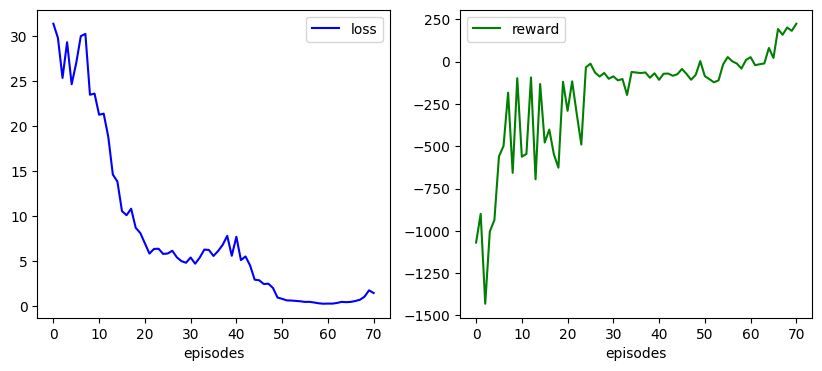

In [26]:
# Plot loss and accuracy
def plot_graphs(log_history, log_labels, graph_labels, graph_colors=['b-','g-']):
    num_graphs = len(log_labels)
    plt.figure(figsize=(5*num_graphs,4))
    for i in range(num_graphs):
        plt.subplot(1,num_graphs,i+1)
        plt.plot(log_history[log_labels[i]], graph_colors[i], label=graph_labels[i])
        plt.xlabel('episodes')
        plt.legend()
    plt.show()
    return

# Define the labels
log_labels    = ['pi_loss', 'vreward']
label_strings = ['loss', 'reward']
label_colors  = ['b-', 'g-']
plot_graphs(logs.history, log_labels, label_strings, label_colors)

### Evaluate the Agent

Since a single evaluation try often takes some time, evaluate the agent here to show the progress bar

In [27]:
evaluate_episodes = 20 # Set the number of episodes for evaluation
sum_episode_rewards = 0.0 # Initialize the sum of episode rewards
pbar = tqdm(range(evaluate_episodes))

for i in pbar:
    # Evaluate the policy for each episode
    sum_episode_rewards += evaluate_policy(env, agent, 1)

env.close()

print('Evaluation Result:',  sum_episode_rewards/evaluate_episodes)

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation Result: 146.06925780077114


## Show How The Agent Works

In [30]:
env = create_env() # Create the environment
# Wrap the environment to record videos
env = wrappers.RecordVideo(env, video_folder='./gym-results/', name_prefix=res_prefix)
# Evaluate the agent's policy
eval_reward = evaluate_policy(env, agent, 1)

print('Sample Total Reward:', eval_reward)

env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/gym-results folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Sample Total Reward: 207.9398907515973


In [31]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 320):
  # Read the video file in binary mode
  video_file = open(video_path, "r+b").read()
  # Encode the video in base64 format to embed in HTML
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  # Return HTML video player with the embedded base64 video
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

# Display the video using the function
show_video('./gym-results/' + res_prefix + '-episode-0.mp4')

(c) 2024 SW Lee